# Análisis Posts Insta Lemus

In [1]:
# Importamos las librerías

import re
import nltk
import pandas as pd
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from nltk.tokenize import RegexpTokenizer

import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

###Diccionarios en español para el análisis de polaridad
nltk.download('punkt')
# Tokenización
# Descargar el conjunto de stopwords en español si no lo tienes
nltk.download('stopwords')
# Análisis de polaridad
# Obtención de listado de stopwords del inglés
stop_words = list(stopwords.words('spanish'))

[nltk_data] Downloading package punkt to /home/milton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/milton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_posts = pd.read_csv("instagram_lemus.csv", usecols=["_aacl", "x1i10hfl 2"])

df_posts["texto"] = df_posts._aacl + ' ' + df_posts["x1i10hfl 2"]
df_posts = df_posts.drop("_aacl", axis=1)
df_posts = df_posts.drop("x1i10hfl 2", axis=1)
df_posts = df_posts.dropna()
df_posts

,texto
2,"Así como lo hicimos en Zapopan, en Guadalajara..."
6,Recibimos con mucha humildad y agradecimiento ...
9,Chequen nomás la que nos prepararon en San Ju...
12,Visitamos el oriente de la ciudad para una ent...
15,"Después de algunos años de espera, hoy fuimos ..."
...,...
830,Los Mercados Municipales son motores de desarr...
845,Servir a Guadalajara es un privilegio que valo...
848,🔆Desde hace dos años hemos trabajado bien y de...
869,Trabajamos bien y de buenas por un más chulo ...


In [3]:
import re
import emoji

def limpiar_texto(texto):
    # Eliminar caracteres especiales y números
    texto_limpio = re.sub(r'[^\w\sáéíóúüÁÉÍÓÚÜñ]', '', texto, flags=re.UNICODE)
    # Eliminar espacios en blanco adicionales y convertir a minúsculas
    texto_limpio = ' '.join(texto_limpio.split()).lower()
    return texto_limpio

df_posts["texto"] = df_posts["texto"].apply(limpiar_texto)
df_posts_clean = df_posts.copy()



In [4]:
df_posts['texto'] = df_posts['texto'].str.lower()
tokenizer = RegexpTokenizer(r'\w+')
df_posts['tokens'] = df_posts['texto'].apply(tokenizer.tokenize)
df_posts.to_csv("posts_insta.csv")
df_posts

,texto,tokens
2,así como lo hicimos en zapopan en guadalajara ...,"[así, como, lo, hicimos, en, zapopan, en, guad..."
6,recibimos con mucha humildad y agradecimiento ...,"[recibimos, con, mucha, humildad, y, agradecim..."
9,chequen nomás la que nos prepararon en san jua...,"[chequen, nomás, la, que, nos, prepararon, en,..."
12,visitamos el oriente de la ciudad para una ent...,"[visitamos, el, oriente, de, la, ciudad, para,..."
15,después de algunos años de espera hoy fuimos p...,"[después, de, algunos, años, de, espera, hoy, ..."
...,...,...
830,los mercados municipales son motores de desarr...,"[los, mercados, municipales, son, motores, de,..."
845,servir a guadalajara es un privilegio que valo...,"[servir, a, guadalajara, es, un, privilegio, q..."
848,desde hace dos años hemos trabajado bien y de ...,"[desde, hace, dos, años, hemos, trabajado, bie..."
869,trabajamos bien y de buenas por un más chulo y...,"[trabajamos, bien, y, de, buenas, por, un, más..."


In [5]:
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("q", "d", "van", "si", "pa", "así", "ser", "solo", "tan", "va", "as",
                "le", "con","ella", "qué", "por", "qu", "ers", "das", "ve", "jajaja", "jeje", "La", "nimo", "ms", "da"))

In [6]:
# Filtrado para excluir stopwords
# ==============================================================================
tweets_tidy = df_posts[~(df_posts["tokens"].isin(stop_words))]
tweets_tidy

,texto,tokens
2,así como lo hicimos en zapopan en guadalajara ...,"[así, como, lo, hicimos, en, zapopan, en, guad..."
6,recibimos con mucha humildad y agradecimiento ...,"[recibimos, con, mucha, humildad, y, agradecim..."
9,chequen nomás la que nos prepararon en san jua...,"[chequen, nomás, la, que, nos, prepararon, en,..."
12,visitamos el oriente de la ciudad para una ent...,"[visitamos, el, oriente, de, la, ciudad, para,..."
15,después de algunos años de espera hoy fuimos p...,"[después, de, algunos, años, de, espera, hoy, ..."
...,...,...
830,los mercados municipales son motores de desarr...,"[los, mercados, municipales, son, motores, de,..."
845,servir a guadalajara es un privilegio que valo...,"[servir, a, guadalajara, es, un, privilegio, q..."
848,desde hace dos años hemos trabajado bien y de ...,"[desde, hace, dos, años, hemos, trabajado, bie..."
869,trabajamos bien y de buenas por un más chulo y...,"[trabajamos, bien, y, de, buenas, por, un, más..."


In [7]:
##########NUBE DE PALABRAS
def preprocess_text(text):
    words = text # Tokenizar y convertir a minúsculas
    words = [word for word in words if word.isalpha()]  # Eliminar caracteres no alfabéticos
    words = [word for word in words if word not in stop_words]  # Eliminar palabras vacías
    return words


preprocessed_text = tweets_tidy["tokens"].apply(preprocess_text)

preprocessed_text

2      [hicimos, zapopan, guadalajara, propusimos, go...
6      [recibimos, mucha, humildad, agradecimiento, r...
9      [chequen, nomás, prepararon, san, juan, dios, ...
12     [visitamos, oriente, ciudad, entrega, nidos, l...
15     [después, años, espera, hoy, parte, inauguraci...
                             ...                        
830    [mercados, municipales, motores, desarrollo, e...
845    [servir, guadalajara, privilegio, valoro, cada...
848    [hace, dos, años, trabajado, bien, buenas, con...
869    [trabajamos, bien, buenas, chulo, lleno, vidaá...
872    [listos, informar, tapatías, tapatíos, hecho, ...
Name: tokens, Length: 188, dtype: object

In [8]:
# Unimos todas las listas de palabras en una sola lista
all_words = [word for sublist in preprocessed_text.values for word in sublist]

# Creamos un DataFrame con las palabras y sus frecuencias
word_counts = pd.Series(all_words).value_counts()

# Tomamos las palabras más comunes (puedes ajustar este valor según tus necesidades)
top_words = word_counts.head(10)
top_words.to_csv("top_words_posts.csv")
type(top_words)

pandas.core.series.Series

In [9]:
word_counts

guadalajara    139
ánimo          111
ciudad          72
mejor           57
jalisco         50
              ... 
cuarto           1
vienen           1
creer            1
regidoras        1
lugaránimo       1
Name: count, Length: 2781, dtype: int64

In [10]:
# Unir las palabras en un solo texto (separadas por espacios)
texto = " ".join(all_words)
# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(texto)
# Mostrar la nube de palabras utilizando matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Desactivar ejes
plt.show()

ValueError: Only supported for TrueType fonts

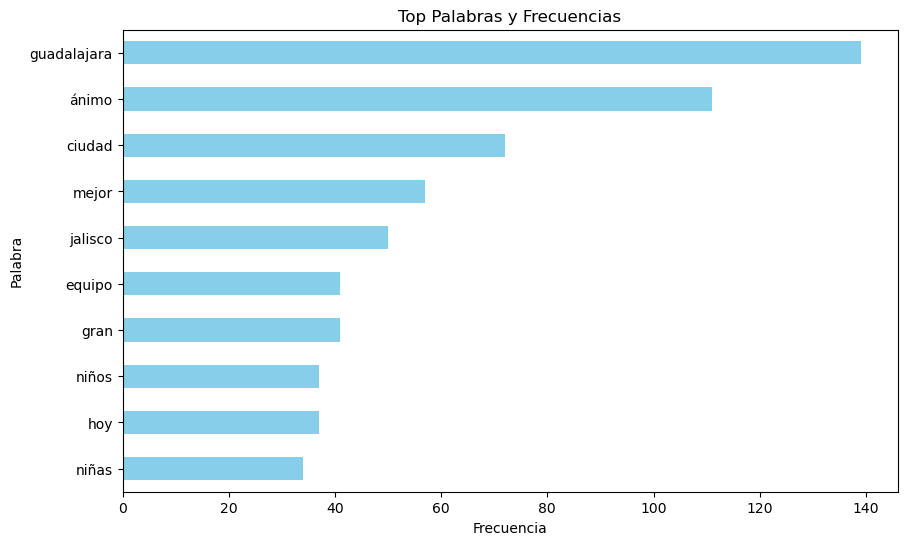

In [11]:
# Crear el gráfico de barras horizontal
plt.figure(figsize=(10, 6))
top_words.plot(kind='barh', color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.title('Top Palabras y Frecuencias')
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar la palabra con la frecuencia más alta en la parte superior
plt.show()

In [12]:
tweets_tidy.tokens

2      [así, como, lo, hicimos, en, zapopan, en, guad...
6      [recibimos, con, mucha, humildad, y, agradecim...
9      [chequen, nomás, la, que, nos, prepararon, en,...
12     [visitamos, el, oriente, de, la, ciudad, para,...
15     [después, de, algunos, años, de, espera, hoy, ...
                             ...                        
830    [los, mercados, municipales, son, motores, de,...
845    [servir, a, guadalajara, es, un, privilegio, q...
848    [desde, hace, dos, años, hemos, trabajado, bie...
869    [trabajamos, bien, y, de, buenas, por, un, más...
872    [estamos, listos, para, informar, a, las, tapa...
Name: tokens, Length: 188, dtype: object

In [13]:
texts = tweets_tidy.tokens

punctuation = set(string.punctuation)

texts = [[word for word in doc if word not in stop_words and word not in punctuation] for doc in texts]

# Crear un diccionario de términos a partir del corpus
dictionary = corpora.Dictionary(texts)

# Crear una representación vectorial del corpus
corpus = [dictionary.doc2bow(text) for text in texts]

In [14]:
# Entrenar el modelo LDA
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Obtener los temas y sus palabras clave
topics = lda_model.print_topics(num_words=10)

# Mostrar los temas y sus palabras clave
for topic in topics:
    print(topic)

(0, '0.008*"guadalajara" + 0.008*"ánimo" + 0.006*"ciudad" + 0.006*"gran" + 0.005*"viernes" + 0.005*"centro" + 0.005*"mercado" + 0.004*"alcalde" + 0.004*"cada" + 0.004*"hoy"')
(1, '0.019*"guadalajara" + 0.016*"ánimo" + 0.012*"ciudad" + 0.011*"mejor" + 0.008*"equipo" + 0.008*"jalisco" + 0.007*"bien" + 0.006*"todas" + 0.005*"vamos" + 0.005*"años"')
(2, '0.007*"mejor" + 0.006*"día" + 0.006*"guadalajara" + 0.006*"mercado" + 0.006*"ánimo" + 0.006*"personas" + 0.005*"gran" + 0.005*"gracias" + 0.005*"jalisco" + 0.004*"programa"')
(3, '0.016*"guadalajara" + 0.010*"ánimo" + 0.007*"ciudad" + 0.005*"tapatíos" + 0.004*"mercados" + 0.004*"nuevo" + 0.004*"gran" + 0.004*"hoy" + 0.003*"plaza" + 0.003*"méxico"')
(4, '0.013*"guadalajara" + 0.009*"niños" + 0.009*"ánimo" + 0.009*"niñas" + 0.006*"seguir" + 0.005*"civil" + 0.005*"protección" + 0.005*"atención" + 0.004*"mejores" + 0.004*"jalisco"')


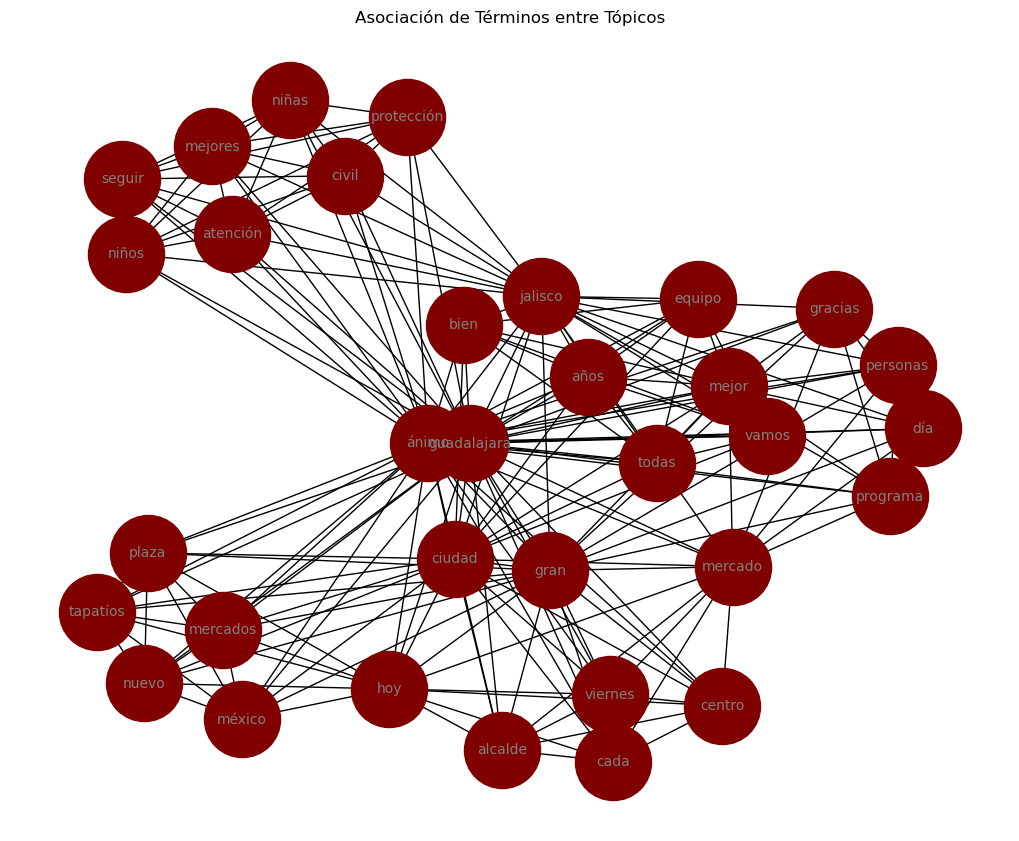

In [15]:
import networkx as nx

# Crear un grafo de red
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Dibujar el gráfico de red
pos = nx.spring_layout(G, k=0.3, iterations=50)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=3000, node_color='maroon', font_color='gray')

# Mostrar el gráfico de red
plt.title('Asociación de Términos entre Tópicos')
# Guardar la figura como una imagen
plt.savefig('topicos.png', bbox_inches='tight', dpi=300)
plt.show()

# Opción 2 Topics

In [16]:
import spacy

nlp = spacy.load("es_core_news_sm")

# Función para preprocesar el texto
def preprocess_text(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

# Aplicar el preprocesamiento a cada fila del DataFrame
df_posts['texto_preprocesado'] = df_posts['texto'].apply(preprocess_text)
df_posts

,texto,tokens,texto_preprocesado
2,así como lo hicimos en zapopan en guadalajara ...,"[así, como, lo, hicimos, en, zapopan, en, guad...","[hacer, zapopar, guadalajara, propusimos, gobi..."
6,recibimos con mucha humildad y agradecimiento ...,"[recibimos, con, mucha, humildad, y, agradecim...","[recibir, humildad, agradecimiento, resultado,..."
9,chequen nomás la que nos prepararon en san jua...,"[chequen, nomás, la, que, nos, prepararon, en,...","[checar, nomás, preparar, san, juan, dio, chid..."
12,visitamos el oriente de la ciudad para una ent...,"[visitamos, el, oriente, de, la, ciudad, para,...","[visitar, oriente, ciudad, entrega, nido, lluv..."
15,después de algunos años de espera hoy fuimos p...,"[después, de, algunos, años, de, espera, hoy, ...","[año, espera, inauguración, avenida, paseo, ro..."
...,...,...,...
830,los mercados municipales son motores de desarr...,"[los, mercados, municipales, son, motores, de,...","[mercado, municipal, motor, desarrollo, económ..."
845,servir a guadalajara es un privilegio que valo...,"[servir, a, guadalajara, es, un, privilegio, q...","[servir, guadalajara, privilegio, valoro, desp..."
848,desde hace dos años hemos trabajado bien y de ...,"[desde, hace, dos, años, hemos, trabajado, bie...","[año, trabajar, construir, ciudad, todosdesde,..."
869,trabajamos bien y de buenas por un más chulo y...,"[trabajamos, bien, y, de, buenas, por, un, más...","[trabajar, chulo, lleno, vidaánimo, poner, cen..."


In [17]:
from gensim import corpora

# Crear un diccionario a partir de los documentos preprocesados
dictionary = corpora.Dictionary(df_posts['texto_preprocesado'])

# Crear una representación BoW de los documentos
corpus = [dictionary.doc2bow(texto) for texto in df_posts['texto_preprocesado']]

In [18]:
from gensim.models import LdaModel

num_topics = 5  # Ajusta el número de tópicos según tus necesidades
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

In [19]:
# Obtener los temas y sus palabras clave
topics = lda_model.print_topics(num_words=10)

# Mostrar los temas y sus palabras clave
for topic in topics:
    print(topic)

(0, '0.028*"mercado" + 0.008*"médico" + 0.008*"seguir" + 0.008*"ciudad" + 0.007*"municipal" + 0.007*"espacio" + 0.007*"trabajar" + 0.006*"ánimo" + 0.006*"programa" + 0.005*"guadalajara"')
(1, '0.021*"guadalajara" + 0.020*"ánimo" + 0.011*"ciudad" + 0.010*"calle" + 0.007*"espacio" + 0.007*"tapatío" + 0.006*"recorrido" + 0.006*"público" + 0.006*"trabajar" + 0.006*"niño"')
(2, '0.013*"guadalajara" + 0.010*"ciudad" + 0.008*"niña" + 0.008*"niño" + 0.008*"trabajar" + 0.007*"seguir" + 0.007*"mercado" + 0.007*"espacio" + 0.006*"ánimo" + 0.006*"año"')
(3, '0.012*"ánimo" + 0.012*"guadalajara" + 0.012*"jalisco" + 0.009*"seguir" + 0.009*"centro" + 0.008*"niño" + 0.007*"niña" + 0.006*"trabajar" + 0.006*"espacio" + 0.006*"programa"')
(4, '0.024*"guadalajara" + 0.018*"ánimo" + 0.012*"jalisco" + 0.009*"ciudad" + 0.008*"seguir" + 0.007*"año" + 0.006*"junto" + 0.006*"servicio" + 0.005*"público" + 0.005*"trabajar"')


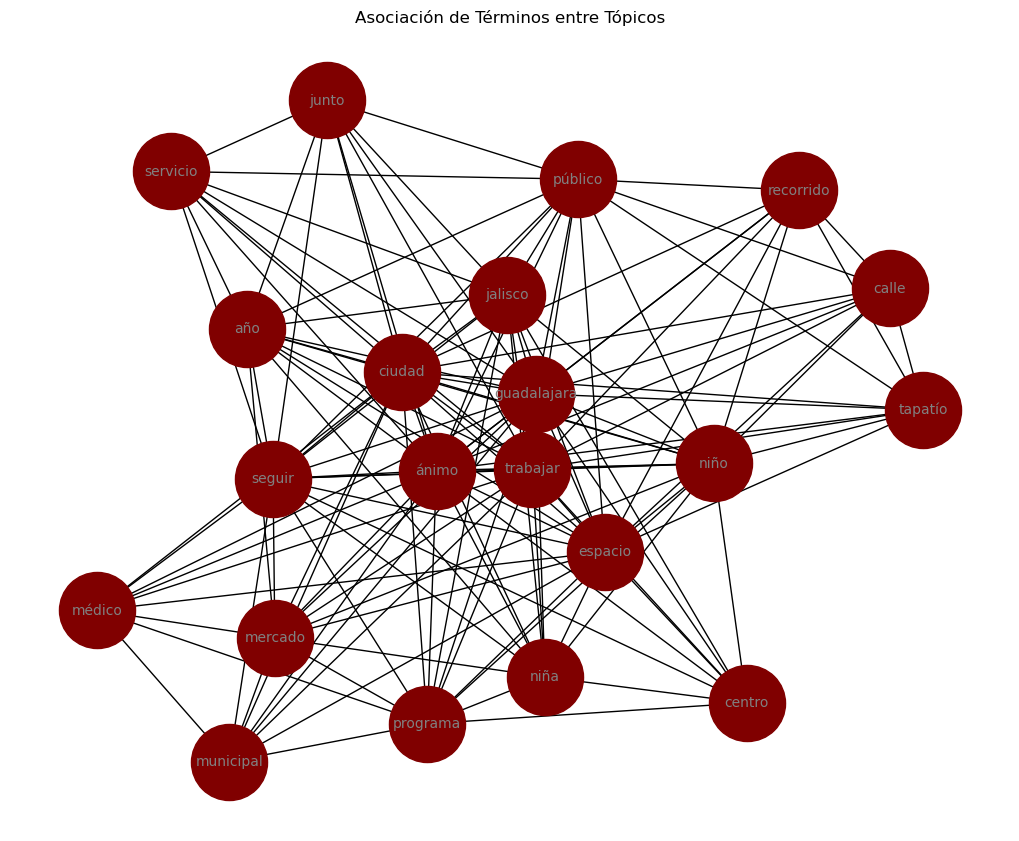

In [20]:
import networkx as nx

# Crear un grafo de red
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Dibujar el gráfico de red
pos = nx.spring_layout(G, k=0.3, iterations=50)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=3000, node_color='maroon', font_color='gray')

# Mostrar el gráfico de red
plt.title('Asociación de Términos entre Tópicos')
# Guardar la figura como una imagen
plt.savefig('topicos.png', bbox_inches='tight', dpi=300)
plt.show()

In [21]:
import pandas as pd
import spacy
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

# Generación de bigramas con spaCy
nlp = spacy.load("es_core_news_sm")

def generar_bigramas_spacy(texto):
    doc = nlp(texto)
    bigramas = [(doc[i].text, doc[i + 1].text) for i in range(len(doc) - 1)]
    return bigramas

df_posts_clean['bigramas_spacy'] = df_posts_clean['texto'].apply(generar_bigramas_spacy)

# Generación de bigramas con NLTK
def generar_bigramas_nltk(texto):
    tokens = word_tokenize(texto)
    bigramas = list(ngrams(tokens, 2))
    return bigramas

df_posts_clean['bigramas_nltk'] = df_posts_clean['texto'].apply(generar_bigramas_nltk)

# Visualización del DataFrame resultante
df_posts_clean


,texto,bigramas_spacy,bigramas_nltk
2,así como lo hicimos en zapopan en guadalajara ...,"[(así, como), (como, lo), (lo, hicimos), (hici...","[(así, como), (como, lo), (lo, hicimos), (hici..."
6,recibimos con mucha humildad y agradecimiento ...,"[(recibimos, con), (con, mucha), (mucha, humil...","[(recibimos, con), (con, mucha), (mucha, humil..."
9,chequen nomás la que nos prepararon en san jua...,"[(chequen, nomás), (nomás, la), (la, que), (qu...","[(chequen, nomás), (nomás, la), (la, que), (qu..."
12,visitamos el oriente de la ciudad para una ent...,"[(visitamos, el), (el, oriente), (oriente, de)...","[(visitamos, el), (el, oriente), (oriente, de)..."
15,después de algunos años de espera hoy fuimos p...,"[(después, de), (de, algunos), (algunos, años)...","[(después, de), (de, algunos), (algunos, años)..."
...,...,...,...
830,los mercados municipales son motores de desarr...,"[(los, mercados), (mercados, municipales), (mu...","[(los, mercados), (mercados, municipales), (mu..."
845,servir a guadalajara es un privilegio que valo...,"[(servir, a), (a, guadalajara), (guadalajara, ...","[(servir, a), (a, guadalajara), (guadalajara, ..."
848,desde hace dos años hemos trabajado bien y de ...,"[(desde, hace), (hace, dos), (dos, años), (año...","[(desde, hace), (hace, dos), (dos, años), (año..."
869,trabajamos bien y de buenas por un más chulo y...,"[(trabajamos, bien), (bien, y), (y, de), (de, ...","[(trabajamos, bien), (bien, y), (y, de), (de, ..."


In [22]:
import pandas as pd
import spacy

# Cargar el modelo de spaCy en español
nlp = spacy.load("es_core_news_sm")

# Función para lematizar el texto
def lematizar_texto(texto):
    doc = nlp(texto)
    lemas = [token.lemma_ for token in doc]
    return " ".join(lemas)

# Aplicar la función de lematización a cada fila del DataFrame
df_posts_clean['texto_lematizado'] = df_posts_clean['texto'].apply(lematizar_texto)

# Visualización del DataFrame resultante
df_posts_clean

,texto,bigramas_spacy,bigramas_nltk,texto_lematizado
2,así como lo hicimos en zapopan en guadalajara ...,"[(así, como), (como, lo), (lo, hicimos), (hici...","[(así, como), (como, lo), (lo, hicimos), (hici...",así como él hacer en zapopar en guadalajara yo...
6,recibimos con mucha humildad y agradecimiento ...,"[(recibimos, con), (con, mucha), (mucha, humil...","[(recibimos, con), (con, mucha), (mucha, humil...",recibir con mucho humildad y agradecimiento el...
9,chequen nomás la que nos prepararon en san jua...,"[(chequen, nomás), (nomás, la), (la, que), (qu...","[(chequen, nomás), (nomás, la), (la, que), (qu...",checar nomás el que yo preparar en san juan de...
12,visitamos el oriente de la ciudad para una ent...,"[(visitamos, el), (el, oriente), (oriente, de)...","[(visitamos, el), (el, oriente), (oriente, de)...",visitar el oriente de el ciudad para uno entre...
15,después de algunos años de espera hoy fuimos p...,"[(después, de), (de, algunos), (algunos, años)...","[(después, de), (de, algunos), (algunos, años)...",después de alguno año de espera hoy ir parte d...
...,...,...,...,...
830,los mercados municipales son motores de desarr...,"[(los, mercados), (mercados, municipales), (mu...","[(los, mercados), (mercados, municipales), (mu...",el mercado municipal ser motor de desarrollo e...
845,servir a guadalajara es un privilegio que valo...,"[(servir, a), (a, guadalajara), (guadalajara, ...","[(servir, a), (a, guadalajara), (guadalajara, ...",servir a guadalajara ser uno privilegio que va...
848,desde hace dos años hemos trabajado bien y de ...,"[(desde, hace), (hace, dos), (dos, años), (año...","[(desde, hace), (hace, dos), (dos, años), (año...",desde hacer dos año haber trabajar bien y de b...
869,trabajamos bien y de buenas por un más chulo y...,"[(trabajamos, bien), (bien, y), (y, de), (de, ...","[(trabajamos, bien), (bien, y), (y, de), (de, ...",trabajar bien y de buena por uno más chulo y l...


In [23]:
# Aplicar el preprocesamiento a cada fila del DataFrame
df_posts_clean['texto_preprocesado'] = df_posts_clean['texto_lematizado'].apply(preprocess_text)

# Crear un diccionario a partir de los documentos preprocesados
dictionary = corpora.Dictionary(df_posts_clean['texto_preprocesado'])

# Crear una representación BoW de los documentos
corpus = [dictionary.doc2bow(texto) for texto in df_posts_clean['texto_preprocesado']]

num_topics = 5  # Ajusta el número de tópicos según tus necesidades
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# Obtener los temas y sus palabras clave
topics = lda_model.print_topics(num_words=10)

# Mostrar los temas y sus palabras clave
for topic in topics:
    print(topic)

(0, '0.028*"mercado" + 0.013*"guadalajara" + 0.013*"ánimo" + 0.008*"colonia" + 0.006*"ciudad" + 0.006*"rehabilitación" + 0.006*"centro" + 0.006*"concreto" + 0.006*"vecino" + 0.006*"equipo"')
(1, '0.009*"médico" + 0.008*"seguir" + 0.007*"tapatío" + 0.007*"guadalajara" + 0.007*"jalisco" + 0.006*"ánimo" + 0.006*"atención" + 0.006*"municipal" + 0.005*"actividad" + 0.005*"ciudad"')
(2, '0.022*"ánimo" + 0.022*"guadalajara" + 0.016*"ciudad" + 0.010*"trabajar" + 0.009*"público" + 0.008*"año" + 0.008*"jalisco" + 0.007*"equipo" + 0.007*"evento" + 0.007*"calle"')
(3, '0.016*"guadalajara" + 0.013*"ánimo" + 0.012*"seguir" + 0.009*"ciudad" + 0.009*"niña" + 0.009*"niño" + 0.008*"trabajar" + 0.006*"familia" + 0.006*"espacio" + 0.006*"tapatío"')
(4, '0.019*"guadalajara" + 0.011*"ánimo" + 0.010*"espacio" + 0.009*"niño" + 0.009*"jalisco" + 0.008*"niña" + 0.007*"seguir" + 0.007*"trabajar" + 0.006*"tapatío" + 0.006*"ciudad"')


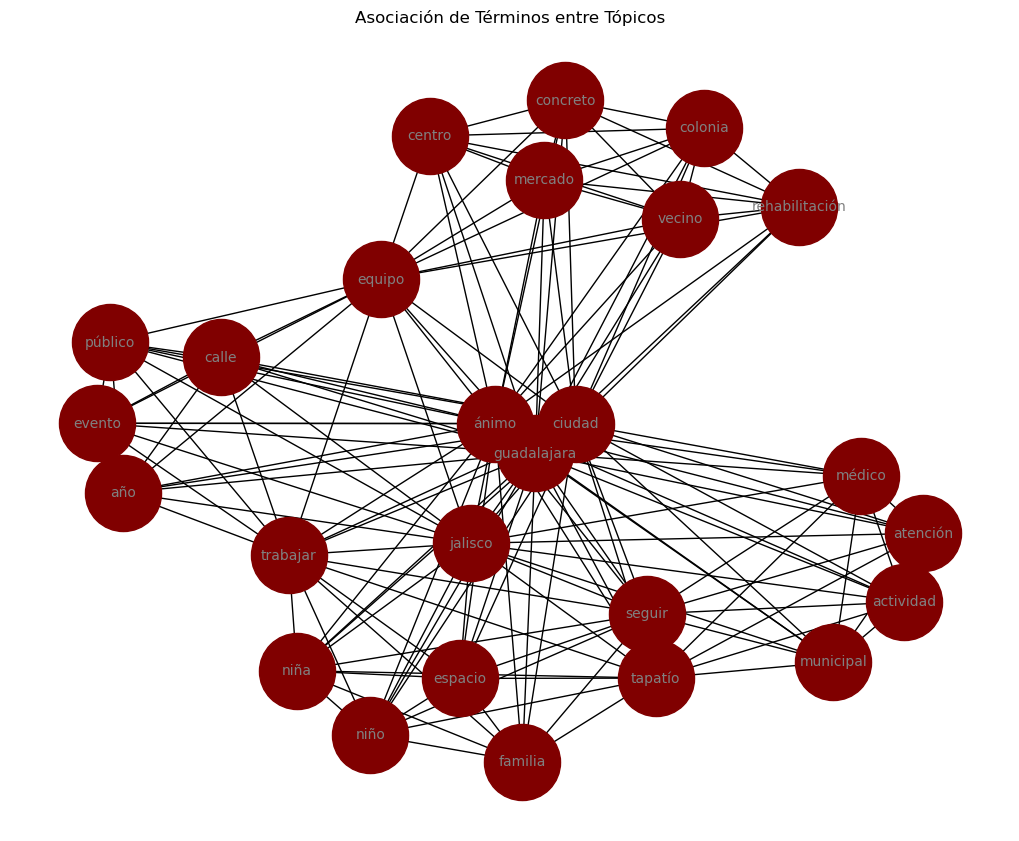

In [24]:
# Crear un grafo de red
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Dibujar el gráfico de red
pos = nx.spring_layout(G, k=0.3, iterations=50)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=3000, node_color='maroon', font_color='gray')

# Mostrar el gráfico de red
plt.title('Asociación de Términos entre Tópicos')
# Guardar la figura como una imagen
plt.savefig('topicos.png', bbox_inches='tight', dpi=300)
plt.show()

In [25]:
import networkx as nx
import plotly.graph_objects as go

# Crear un grafo de NetworkX
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Obtener las posiciones de los nodos en el gráfico
pos = nx.spring_layout(G, k=0.3, iterations=50)

# Extraer las posiciones X e Y de los nodos
pos_x = {node: pos[node][0] for node in G.nodes}
pos_y = {node: pos[node][1] for node in G.nodes}

# Crear un objeto de grafo de Plotly
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos_x[edge[0]], pos_y[edge[0]]
    x1, y1 = pos_x[edge[1]], pos_y[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = list(pos_x.values())
node_y = list(pos_y.values())

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        size=10,
        colorbar=dict(thickness=15, title='Node Connections'),
        line_width=2))

node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# de conexiones: ' + str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

# Crear la figura de Plotly
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                showlegend=False,
                hovermode='closest',
                margin=dict(b=0, l=0, r=0, t=0),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

# Mostrar la figura
fig.update_layout(title='Asociación de Términos entre Tópicos', title_x=0.5)
fig.show()


In [26]:
# Crear un conjunto de términos únicos
unique_terms = set()
for topic_id, topic_words in topics:
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    unique_terms.update(terms)

# Crear listas para nodos y enlaces
nodes = list(unique_terms)
source_indices = []
target_indices = []
values = []

# Procesar los tópicos y sus palabras clave para identificar las conexiones
for topic_id, topic_words in topics:
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    for term in terms:
        source_indices.append(nodes.index(term))
        target_indices.append(len(nodes) + topic_id)  # Cada tema se representa como un nodo adicional
        values.append(1)

# Crear un diagrama de Sankey
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes  # Etiquetas de los términos
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values
    )
))

# Mostrar el diagrama de Sankey
fig.update_layout(title_text="Diagrama de Sankey de Tópicos y Términos")
fig.show()